# Model Training for MUBA

In [17]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder

In [18]:
# dir_path points towards where to find the image dataset
dir_path = "data/archive/Dataset_BUSI_with_GT/"
IMAGE_SHAPE = (224, 224)

random_sample = 100

# IMPORTANT - Check these are correct

MIXUP = False # Whether to train the model with mixup
ITERS = 1 # How many mixup images to create per image
BETA = False # Whether to sample from the beta function
BALANCE = True # Whether to balance the data and over-sample certain classes
AUG = True # whether to augment the data


In [19]:
# The data augmentation to do. This applies a random horizontal flip and a random tilt.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation((-0.05, 0.05)),
])

# create prepare_image method
# used to preprocess the image for efficientNet model

def prepare_image(file1: str, label1: str, file2: str = None, label2: str = None, beta = False, augment = True):
    """Prepares the image for the model

    Args:
        file1 (str): The path of  the first image
        label1 (str): The label of the first image
        file2 (str, optional): The path of  the second image. If not none, applies mixup. Defaults to None.
        label2 (str, optional): The label of the second image. Defaults to None.
        beta (bool, optional): If true, sample from teh beta function for mixup. Defaults to False.
        augment (bool, optional): If true, apply augmentations. Defaults to True.

    Returns:
        image, label
    """

    # Load the first image, apply augmentations
    img1 = image.load_img(file1, target_size=IMAGE_SHAPE)
    if augment:
        img1 = data_augmentation(img1)
    img_array = image.img_to_array(img1)
    label = label1

    if file2:

        # Load second image, apply augmentations
        img2 = image.load_img(file2, target_size=IMAGE_SHAPE)
        if augment:
            img2 = data_augmentation(img2)
        img_array2 = image.img_to_array(img2)

        # Generate alpha value for MixUp
        alpa = 0
        if beta:
            alpha = np.random.beta(0.2, 0.2, 1)
        else:
            alpha = random.random()

        # Combine the 2 images 
        img_array = (alpha * img_array) + ((1-alpha) * img_array2)
        label     = (alpha * label1) +    ((1-alpha) * label2)

    return tf.keras.applications.efficientnet.preprocess_input (img_array), label

In [20]:
# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)


(1578, 1578)

In [21]:
# Count the number of labels to get an idea of how balanced the dataset is
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{'benign': 891, 'malignant': 421, 'normal': 266}


In [22]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 3)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['benign' 'malignant' 'normal']


In [23]:
# Create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

len(selected_files), len(selected_labels)

(780, 780)

Label is [0.02663087 0.97336913 0.        ]


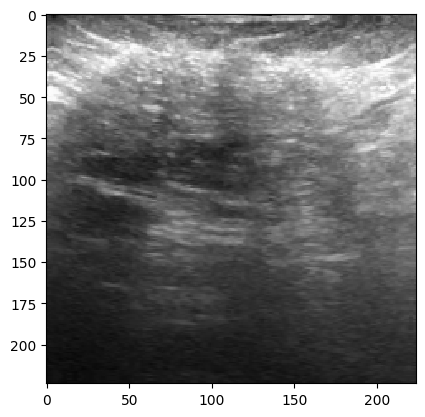

In [24]:
#TEST MIXUP

test_image, label = prepare_image(selected_files[70], selected_labels[70],  selected_files[502], selected_labels[502], False)
test_image = tf.keras.utils.array_to_img(test_image)

print(f"Label is {label}")

plt.imshow(test_image, interpolation='nearest')

In [25]:
# Split the data into testing, training and validation data

x_train, x_tv, y_train, y_tv = train_test_split(selected_files, selected_labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)


In [26]:

# The dictionary holds list of images and for each one has its target/label
images = {
    'image_train': [], 
    'target_train': [],
    'image_test': [], 
    'target_test': [],
    'image_val': [],
    'target_val': []
}

print('Preparing the images...')

def get_balance_iters(label):
    # Returns a value for over-sampling if balancing the data
    if label[0] == 1:
        return 1
    elif label[1] == 1:
        return 2
    else:
        return 3

print("Preparing training data")
for file, label in zip(x_train, y_train):
    # Only go through training data, testing data should not be used for mixup

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):

        if MIXUP == False:
             # Prepare image without mixup
            new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
            images['image_train'].append(new_file)
            images['target_train'].append(new_label)

        elif MIXUP == True:
            # Prepare image with mixup
            # Iterate through the number of ITERS
            for i in range(ITERS):
                # Select a random file index
                random_file_i = random.randint(0,len(selected_files)-1)
                # Mixup the two images
                new_file, new_label = prepare_image(file, label, selected_files[random_file_i],selected_labels[random_file_i], beta = BETA, augment = AUG)
                images['image_train'].append(new_file)
                images['target_train'].append(new_label)

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):
        # Prepare the image
        new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
        images['image_test'].append(new_file)
        images['target_test'].append(new_label)

print("Preparing validation data")
for file, label in zip(x_val, y_val):

    # If balancing the data, use the label to find out how many times to iterate through the image
    if BALANCE == True:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for value in range(balance_iters):
        # Prepare the image
        new_file, new_label = prepare_image(file, label, beta = BETA, augment = AUG)
        images['image_val'].append(new_file)
        images['target_val'].append(new_label)

print('Finished.')

Preparing the images...
Preparing training data
Preparing testing data
Preparing validation data
Finished.


In [37]:
class_counts = [sum(col) for col in zip(*images['target_train'])]
print(f"Benign: {class_counts[0]}  Malignant: {class_counts[1]}  Normal: {class_counts[2]}")

Benign: 306  Malignant: 282  Normal: 297


In [41]:
# convert lists to arrays 
x_train = np.array(images['image_train'])
y_train = np.array(images['target_train'])
x_test  = np.array(images['image_test'])
y_test  = np.array(images['target_test'])
x_val   = np.array(images['image_val'])
y_val   = np.array(images['target_val'])


In [42]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape

((885, 224, 224, 3),
 (175, 224, 224, 3),
 (196, 224, 224, 3),
 (885, 3),
 (175, 3),
 (196, 3))

In [43]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import resnet_v2
base_model = resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])

# incept_model.summary()

In [44]:
EPOCHS = 60 #60
# Trains and returns incept_model. fit ( x_train y_train )
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_simple_model.h5', save_best_only=True) 

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[earlyStop, best_model]) 

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 1.2877 - categorical_accuracy: 0.4215

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 78s 3s/step - loss: 1.2877 - categorical_accuracy: 0.4215 - val_loss: 1.6878 - val_categorical_accuracy: 0.2959
Epoch 2/60
22/28 [======================>.......] - ETA: 12s - loss: 1.0830 - categorical_accuracy: 0.4901

KeyboardInterrupt: 

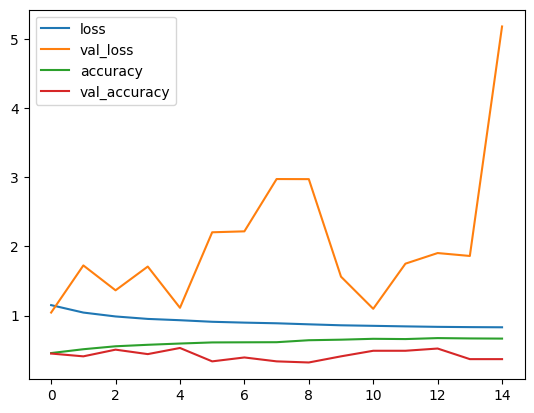

In [20]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['categorical_accuracy'], label='accuracy')
plt.plot(hist['val_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [21]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

4/4 [==============================] - 8s 2s/step - loss: 5.1809 - categorical_accuracy: 0.3710


[5.180875301361084, 0.3709677457809448]

In [22]:
incept_model = keras.models.load_model("best_simple_model.h5")

# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True
    
# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.categorical_crossentropy, metrics=[metrics.CategoricalAccuracy()])

# incept_model.summary()

In [23]:
earlyStop = keras.callbacks.EarlyStopping(patience=60) 
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True) 

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=[earlyStop, best_model]) 

Epoch 1/15
107/107 [==============================] - 264s 2s/step - loss: 0.7994 - categorical_accuracy: 0.6988 - val_loss: 1.0588 - val_categorical_accuracy: 0.5242
Epoch 2/15
107/107 [==============================] - 254s 2s/step - loss: 0.7767 - categorical_accuracy: 0.7153 - val_loss: 0.9082 - val_categorical_accuracy: 0.5565
Epoch 3/15
107/107 [==============================] - 271s 3s/step - loss: 0.7706 - categorical_accuracy: 0.7135 - val_loss: 0.8890 - val_categorical_accuracy: 0.6452
Epoch 4/15
107/107 [==============================] - 287s 3s/step - loss: 0.7688 - categorical_accuracy: 0.7232 - val_loss: 0.7589 - val_categorical_accuracy: 0.6210
Epoch 5/15
107/107 [==============================] - 298s 3s/step - loss: 0.7561 - categorical_accuracy: 0.7353 - val_loss: 0.9172 - val_categorical_accuracy: 0.5645
Epoch 6/15
107/107 [==============================] - 291s 3s/step - loss: 0.7611 - categorical_accuracy: 0.7291 - val_loss: 0.7857 - val_categorical_accuracy: 0.637

In [24]:
x = incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

4/4 [==============================] - 8s 2s/step - loss: 1.9605 - categorical_accuracy: 0.4194


In [64]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = best_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    return pred, label

In [65]:
best_model = keras.models.load_model("best_model_2.h5")

In [66]:
pred_array = []

for i in range(len(x_test)):
    res = best_model.predict(np.expand_dims(x_test[i], axis = 0))
    pred = [0,1,2][np.argmax(res)]
    
    pred_array.append(pred)

print(pred_array)

1/1 [==============================] - 0s 128ms/step
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]


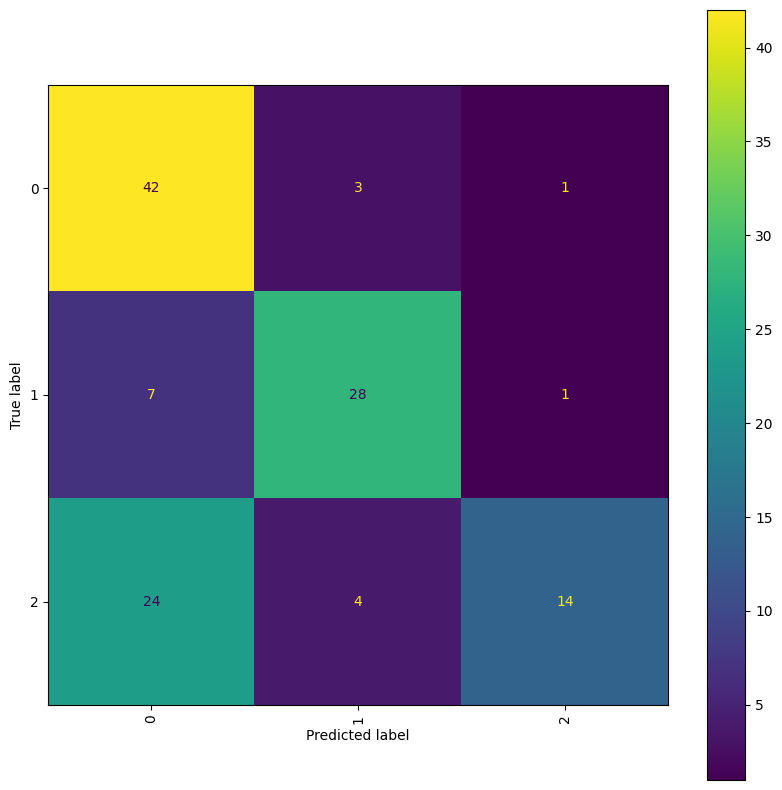

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

y_actual = []
for pred in y_test:
    
    if pred[0] == 1:
        y_actual.append(0)
    if pred[1] == 1:
        y_actual.append(1)
    if pred[2] == 1:
        y_actual.append(2)


fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_actual,
    pred_array,
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

# MUBA


In [24]:
x = selected_files
y = selected_labels

all_lams= []
all_new_labels= []
all_mixed_up_images = []

for img, label in zip(x,y):

    img,label = prepare_image(img, label, None, None, False, False)

    # Get index of label
    i_array = np.where(label == 1)[0]

    while len(i_array) != 3:

        # Get a new mixup image
        mixup_idx = random.randint(0, len(y)-1)
        mixup_image, mixup_label = prepare_image(x[mixup_idx], y[mixup_idx], None, None, False, False)
        mixup_i = np.where(mixup_label == 1)[0][0]

        # Check mixup image has a different label
        if mixup_i not in i_array:
            # Add index to i_array 
            i_array = np.append(i_array, mixup_i)

            # Mixup images
            lam = np.random.rand()
            new_img = lam * img + (1 - lam) * mixup_image   
            new_label = lam * label + (1 - lam) * mixup_label
            #Append images
            all_lams.append(lam)
            all_new_labels.append(new_label)
            all_mixed_up_images.append(new_img)




In [46]:

# Benign - Malignant
bm_img = []
bm_label = []
bm_lams = []
# Benign - Normal
bn_img = []
bn_label = []
bn_lams = []
# Malignant - Normal
mn_img = []
mn_label = []
mn_lams = []

# Classes are ['benign' 'malignant' 'normal']
for image, label, lam in zip(all_mixed_up_images, all_new_labels, all_lams):
    
    if label[0] == 0: # Malignant - Normal
        mn_img.append(image)
        mn_label.append(label)

    if label[1] == 0: # Benign - Normal
        bn_img.append(image)
        bn_label.append(label)

    if label[2] == 0: # Benign - Malignant
        bm_img.append(image)
        bm_label.append(label)

bm_lams = [x[0] for x in bm_label] # % benign in bm pairs
bn_lams = [x[0] for x in bn_label] # % benign in bn pairs
mn_lams = [x[1] for x in mn_label] # % malignant in mn pairs

Text(0.5, 1.0, 'Malignant - Normal Pairs')

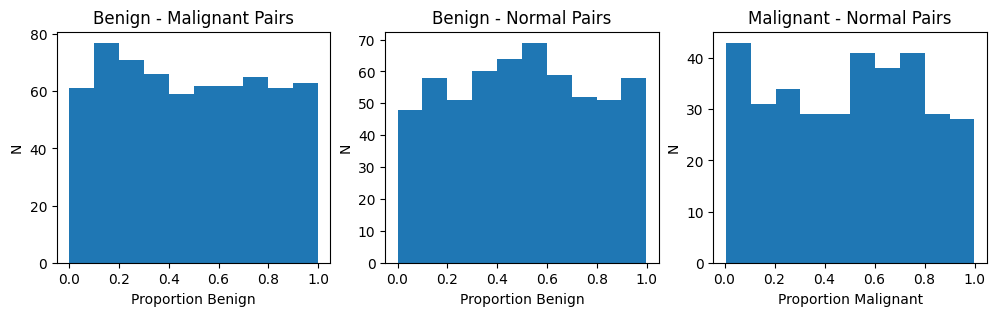

In [48]:
fig, axs = plt.subplots(1,3, figsize = (12,3))

axs[0].hist(bm_lams,bins=10)
axs[0].set_xlabel("Proportion Benign")
axs[0].set_ylabel("N")
axs[0].set_title("Benign - Malignant Pairs")

axs[1].hist(bn_lams,bins=10)
axs[1].set_xlabel("Proportion Benign")
axs[1].set_ylabel("N")
axs[1].set_title("Benign - Normal Pairs")

axs[2].hist(mn_lams,bins=10)
axs[2].set_xlabel("Proportion Malignant")
axs[2].set_ylabel("N")
axs[2].set_title("Malignant - Normal Pairs")


In [103]:
incorrect_mn = []
incorrect_bn = []
incorrect_bm = []

for image, label, lam in zip(mn_img,mn_label, mn_lams):
    res = best_model.predict(np.expand_dims(image, axis = 0))
    prediction = [0,1,2][np.argmax(res)]
    
    if prediction != [0,1,2][np.argmax(label)]:
        incorrect_mn.append(lam)

for image, label, lam in zip(bn_img,bn_label, bn_lams):
    res = best_model.predict(np.expand_dims(image, axis = 0))
    prediction = [0,1,2][np.argmax(res)]
    
    if prediction != [0,1,2][np.argmax(label)]:
        incorrect_bn.append(lam)

for image, label, lam in zip(bm_img,bm_label, bm_lams):
    res = best_model.predict(np.expand_dims(image, axis = 0))
    prediction = [0,1,2][np.argmax(res)]
    
    if prediction != [0,1,2][np.argmax(label)]:
        incorrect_bm.append(lam)


1/1 [==============================] - 1s 864ms/step
[[0.34627867 0.24873284 0.4049885 ]]
[0.         0.51635483 0.48364517]
1/1 [==============================] - 1s 855ms/step


KeyboardInterrupt: 

Skew =  -0.4653953432635652
Skew =  0.20088903361872118


Text(0.5, 1.0, 'Malignant - Normal Pairs')

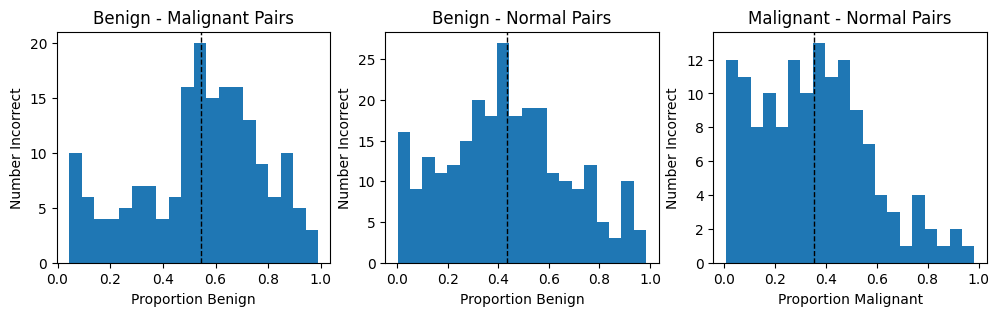

In [94]:
fig, axs = plt.subplots(1,3, figsize = (12,3))

axs[0].hist(incorrect_bm,bins=20)
axs[0].axvline(np.mean(incorrect_bm), color='k', linestyle='dashed', linewidth=1)
print("Skew = " , skew(incorrect_bm))
axs[0].set_xlabel("Proportion Benign")
axs[0].set_ylabel("Number Incorrect")
axs[0].set_title("Benign - Malignant Pairs")

axs[1].hist(incorrect_bn,bins=20)
axs[1].axvline(np.mean(incorrect_bn), color='k', linestyle='dashed', linewidth=1)
print("Skew = " , skew(incorrect_bn))
axs[1].set_xlabel("Proportion Benign")
axs[1].set_ylabel("Number Incorrect")
axs[1].set_title("Benign - Normal Pairs")

axs[2].hist(incorrect_mn,bins=20)
axs[2].axvline(np.mean(incorrect_mn), color='k', linestyle='dashed', linewidth=1)
axs[2].set_xlabel("Proportion Malignant")
axs[2].set_ylabel("Number Incorrect")
axs[2].set_title("Malignant - Normal Pairs")